<div style = 'text-align:center'>

# Tarea N°3 del curso de introducción a Machine Learning en `Python`

## Nombre del Programador: José Gabriel López Madrid
### Correo: `jglopezmad@gmail.com`

</div>



---


<div style = 'text-align:justify'>

<div style = 'text-align:center'>

## Descripción del conjunto de datos

</div>

Tenemos un conjunto de datos financieros de clientes de una institución financiera, los datos tienen relacion con las variables de _Balance_, _Pagos_, _Compras por cuotas_ ,  _Límite de Creditos_ y otros indicadores financieros de los usuarios de la institución. Nuestro objetivo es tomar esos datos y observar la tendencia entre la visualización de los datos via el algoritmo de `Analisis de Componentes Principales` y el **límite de crédito de los usuarios**, es por esto que mostramos primero los módulos utilizados para la creación de este trabajo. Se enumeran todos los módulos necesarios para correr el resto del código aquí. A continuación una pequeña tabla que describe las variables del conjunto de datos.

<center>

| Variable               | Descripción                                                            | Unidad |
| ---------------------- | ---------------------------------------------------------------------- | ------ |
| BALANCE                | Saldo presente en la cuenta.                                           | USD    |
| PURCHASES              | Compras hechas con la tarjeta.                                         | USD    |
| ONE_OFFPURCHASES       | Compras hechas al contado.                                             | USD    |
| INSTALLMENTS_PURCHASES | Compras hechas a plazos.                                               | USD    |
| CASH_ADVANCE           | Compras realizadas pagando <br>  por adelantado.                       | USD    |
| CASH_ADVANCE_TRX       | Numero de compras realizadas  <br> via pagos por adelantado.           |        |
| CREDIT_LIMIT           | Limite de Credito de la tarjeta.                                       | USD    |
| PAYMENTS               | Pagos de la tarjeta realizados por el usuario                          | USD    |
| PRC_FULL_PAYMENT       | Porcentaje del pago total de<br>  la tarjeta realizado por el usuario. |        |

</center>


</div>

In [4]:
# modulos de archivo
import numpy as np
import pandas as pd

pd.set_option('display.precision',2)

#Modulos de matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.cm as cmapp

#Modulos de sklearn para el pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer

#Modulos de sklearn para el metodo de agrupamiento jerarquico y k-medias
from sklearn.cluster import AgglomerativeClustering, KMeans

plt.rcParams.update({
    'text.usetex':True
})

<div style = 'text-align:justify'>

<div style = 'text-align:center'>

## Matriz de correlacion y preprocesado de los datos

</div>
<justify>
Primero se preprocesan los datos, considerando que la data proporcionada todavía posee variables que no son de interés por el momento, sobre todo, queremos eliminar la última columna, que representa la variable `Tenure`. En este caso, no será necesario insertar dicha variable en el modelo, ya que solo tiene información de cuanto tiempo tiene el cliente con esa linea de crédito particular. Como buena práctica, siempre se hará un gráfico de la matriz de correlación para este conjunto de datos, esto con el fin de poder mostrar la matriz de la que se desprende el método de visualización que se muestra más adelante.
</justify>
</div>

In [5]:
# Guardo los datos del .csv en una variable llamada df.
# Por favor, usar los datos completos del dataset de Kaggle. El que se uso en clase me parece que tiene solo 1000 datos, pero queria revisar
# Si con un mayor numero de datos, mejora el resultado.
df = pd.read_csv('/content/drive/MyDrive/CSV/CC_General.csv')
df = df.dropna()
#Luego obtengo las columnas que necesito para solo trabajar con los datos importantes (los que son de tipo numérico,
#las identificaciones de los clientes no me interesan porque son variables categoricas)
x = df[df.columns[1:11]]
#Procedo a realizar la cuestion de revisar la matriz de correlacion para revisar si los datos exhiben correlaciones
#significativas para pasar a la reducción de dimension de los datos para su posterior visualizacion.
mat_corr = x.corr()
mat_vals = mat_corr.values.round(3)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


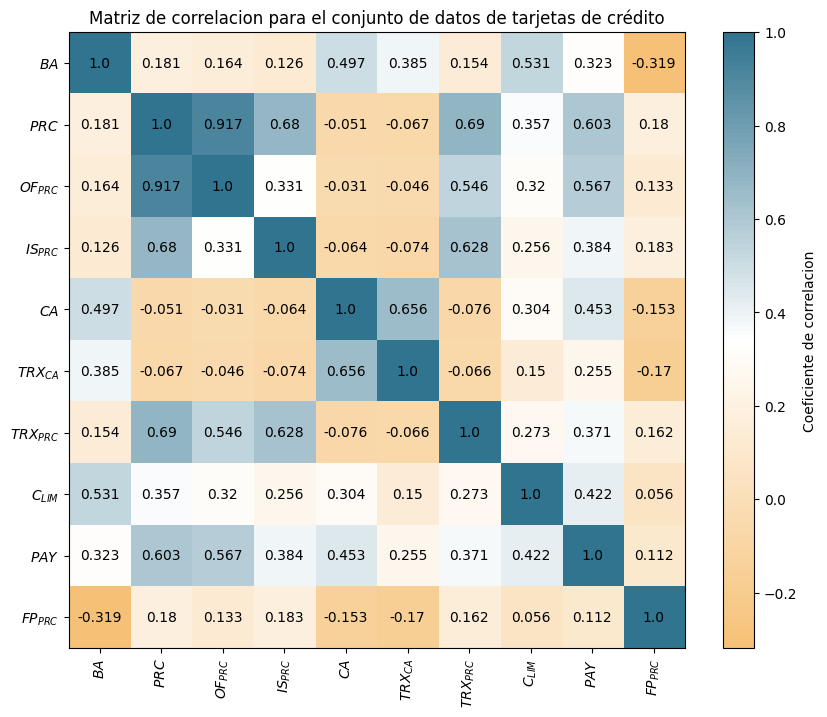

In [7]:
#Todo este código es para poder realizar la matriz de correlacion y observar si existe correlación lineal entre los datos del conjunto.
#Ya de entrada veo que muchas de las variables estan correlacionadas de forma débil, dado que gran parte del conjunto tiene valores que andan entre 0.4 y 0.6
#de correlación, que no es malo, pero es débil.
#Aqui coloco los parametros para realizar una imagen esteticamente satisfactoria.
plt.style.use('default')
pltlabels = ['$BA$','$PRC$','$OF_{PRC}$','$IS_{PRC}$'
             ,'$CA$','$TRX_{CA}$','$TRX_{PRC}$','$C_{LIM}$',
             '$PAY$','$FP_{PRC}$'] # Las etiquetas para los cuadros

#Creacion del esquema de colores, usaré un gradiente con tres colores para realizar el grafico.

clist = [
    (246/255, 193/255, 119/255),
    (1,1,1),
    (49/255, 116/255, 143/255)
]

cm = clr.LinearSegmentedColormap.from_list(name = 'rose_pine', colors = clist, N=128)

plt.figure(figsize=(10,8)) # Tamaño de figura
plt.imshow(X = mat_corr,cmap = cm) # Crear el plot, con la imagen


for i in range(0,10):
    for j in range(0,10):
        plt.text(i,j,mat_vals[i][j], va = 'center', ha = 'center') # Colocar los números que tiene cada coeficiente de correlacion


plt.colorbar().ax.set_ylabel('Coeficiente de correlacion') # Barra de color y titulo de eje
plt.xticks(range(0,10),labels=pltlabels, rotation = 'vertical') #Colocar las etiquetas del eje x
plt.yticks(range(0,10),labels=pltlabels) #Colocar las etiquetas del eje y
plt.title("Matriz de correlacion para el conjunto de datos de tarjetas de crédito") # Titulo
plt.show() #Buena práctica para Python.

## Escalado de datos y preprocesado

Se procede a escalar los datos, por temas de visualizacion, queria observar si dependiendo de la tecnica de visualizacion cambia el resultado final, por esto vamos a realizar dos escalados, que son los que siguen:

1.   Escalado utilizando el `StandardScaler()`, que intenta generar una media de cero y una desviacion estandar de 1 en la escala de la data disponible, el problema de este escalado es que es sensible a valores atipicos.

2.   Escalado usando la funcion `RobustScaler()`, que busca realizar lo mismo que el escalado anterior, pero utiliza otros metodos para realizar dicho escalado (basado en cuantiles), lo que facilita un escalado mas robusto frente a valores atipicos, luego lo que se realiza es utilizar una transformacion de tipo no lineal, para ajustar los valores a que tengan una media de 0 y una desviacion estandar de 1.

Se puede observar que existe una mejora entre los dos metodos, sobre todo, el escalado estandar es, hasta cierto punto, mucho mas dificil de discernir, ademas de tener una cantidad grande de valores anomalos, que podrian cambiar el resultado de una forma significativa. Mientras que el escalado robusto tiene mejores capacidades para la visualizacion de los resultados, lo que lo hace mas idoneo para la presentacion de los resultados que fueron determinados en este cuaderno.



In [8]:
# Se observa que hay una correlacion debil con la cuestion de ciertas variables.

# Se procede a realizar el algoritmo de PCA.

#x_tr = QuantileTransformer().fit_transform(X=x)
x_tr = RobustScaler().fit_transform(X=x)# Se realiza el escalado de los datos.
x_tr = PowerTransformer().fit_transform(X=x_tr)
x_std = StandardScaler().fit_transform(X=x)


pca1 = PCA(n_components=2)
pca2 = PCA(n_components=2)
vis_x = pca1.fit_transform(x_std)
vis_x2 = pca2.fit_transform(x_tr)

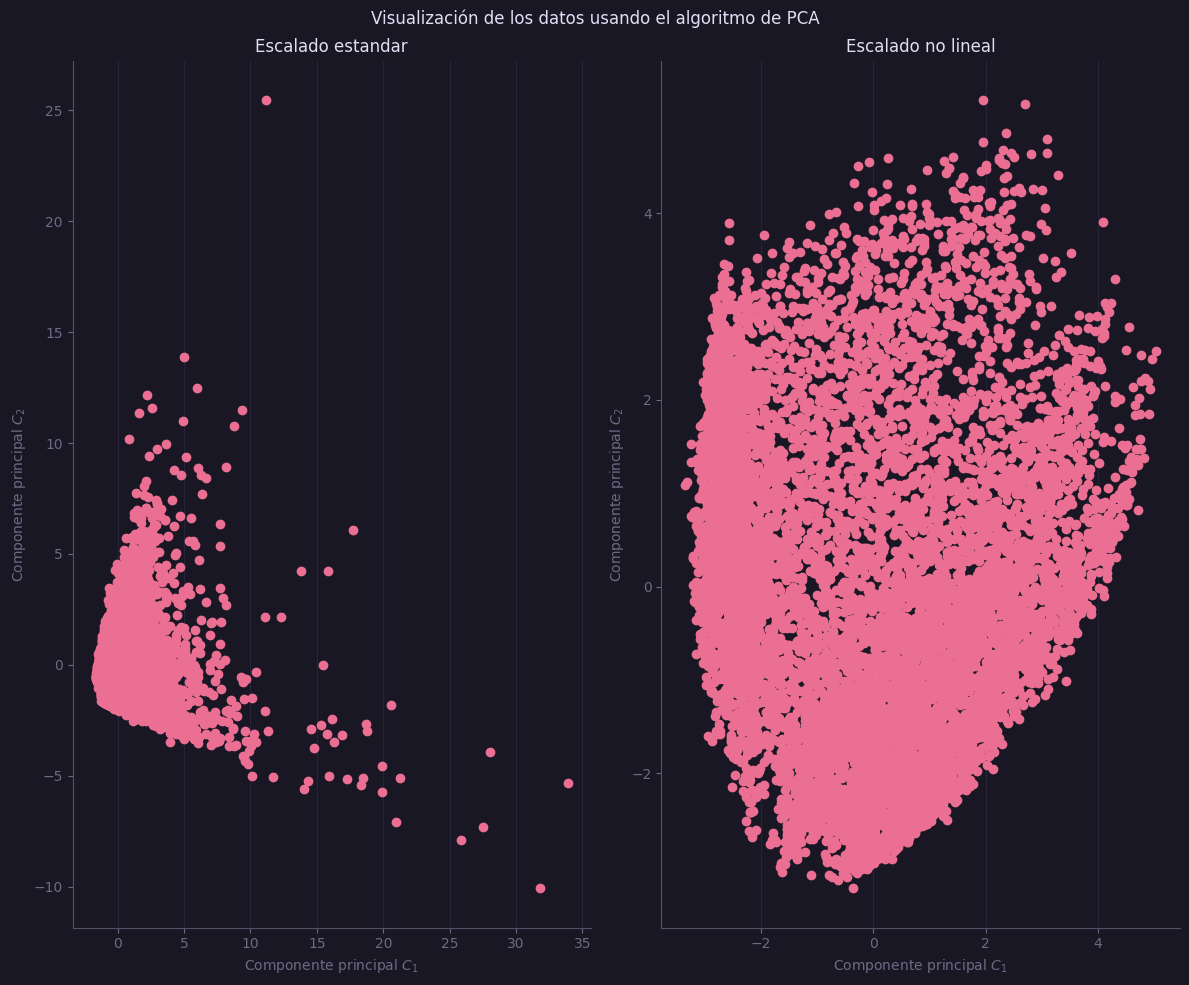

In [9]:
# Se procede a realizar la visualizacion de la data utilizando PCA

plt.style.use('https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine.mplstyle')
plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
plt.grid()
plt.scatter(vis_x[:,0],vis_x[:,1])
plt.xlabel('Componente principal $C_1$')
plt.ylabel('Componente principal $C_2$')
plt.title('Escalado estandar')

plt.subplot(1,2,2)
plt.grid()
plt.scatter(vis_x2[:,0],vis_x2[:,1])
plt.xlabel('Componente principal $C_1$')
plt.ylabel('Componente principal $C_2$')
plt.title('Escalado no lineal')

plt.suptitle('Visualización de los datos usando el algoritmo de PCA')
plt.tight_layout()
plt.show()
#Con el escalado estandar pareciera que hay alrededor de tres puntos que son outliers y están relativamente lejos de los clusters que quiero ver.
#Comparamos este resultado con resultado del escalado por cuantiles.

Se utiliza el metodo del codo para poder determinar un numero optimo para el k usado en el metodo de k-medias. Se muestran a continuacion los resultados para ambos escalados, es notorio ver que el codo pareciera ser mas pronunciado con el escalado robusto, por lo que pareciera que utilizar este escalado mejora los resultados de los metodos no supervisados.

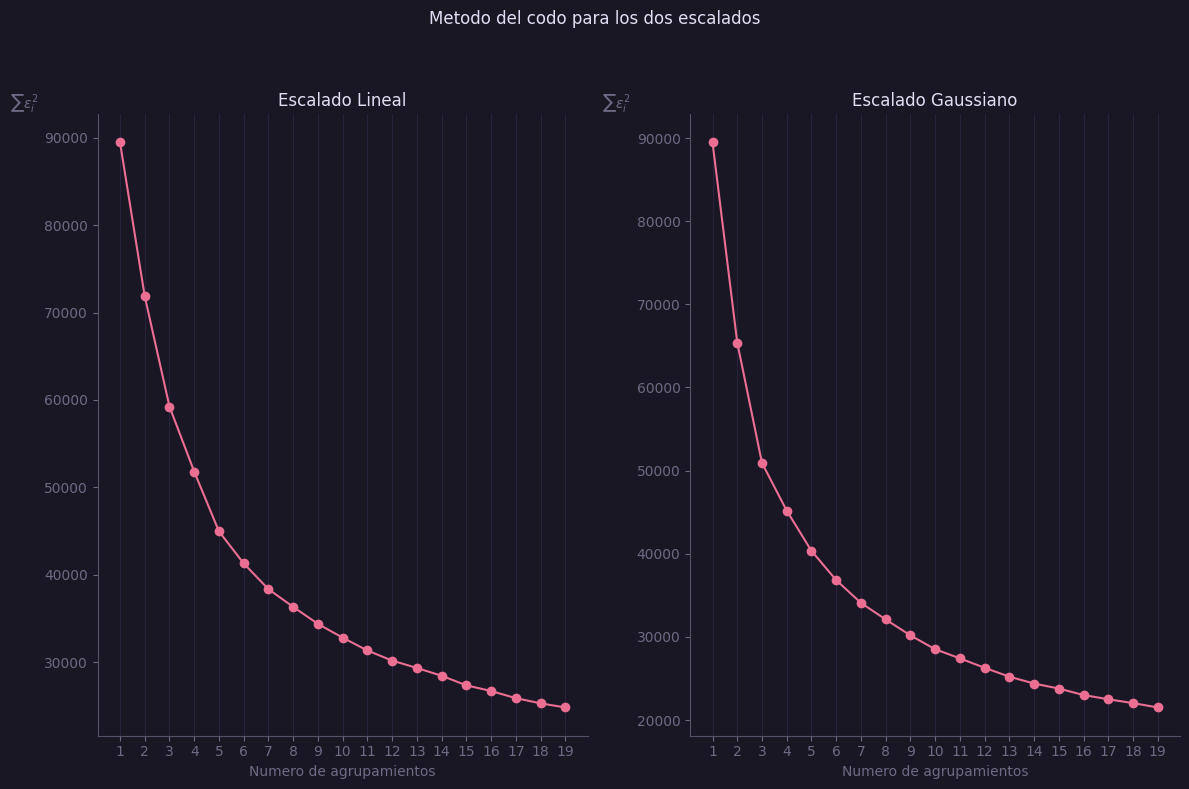

In [10]:
#Parametros para inicializar el metodo del codo, para obtener un k optimo para lo que sería el algoritmo de clustering,
#aunque no puedo dilucidar el codo con detalle, por lo que voy a intentar utilizar otro método, investigando,
#me encontré que había un segundo método para observar esto, que sería usando el coeficiente de silueta.
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

plt.figure(figsize=(12,8))
for i in [1,2]:
    plt.subplot(1,2,i)
    sse = []
    m = 20
    if i == 1:
        a = x_std
    else:
        a = x_tr
    for k in range(1, m):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(a)
        sse.append(kmeans.inertia_)

    etiquetas = ['Lineal', 'Gaussiano']
    plt.grid()
    plt.plot(range(1, m), sse, marker='o')
    plt.xticks(range(1, m))
    plt.xlabel("Numero de agrupamientos")
    plt.ylabel("$\sum \\varepsilon_i ^2$",loc='top',  rotation = 'horizontal')
    plt.title(f'Escalado {etiquetas[i-1]}')
plt.tight_layout()
plt.suptitle('Metodo del codo para los dos escalados')
plt.subplots_adjust(top=0.85)
plt.show()


## Modelo de agrupamiento jerarquico
Se genera el modelo de agrupamiento jerarquico en las siguientes celdas de codigo, lo notorio es que mas adelante se muestra que el metodo de agrupamiento jerarquico entrega resultados parecidos para ambos escalados, lo que da a entender que la ventaja de un escalado por sobre otro es en la visualizacion, nada mas. Si se utiliza el mismo modelo los resultados son los mismos, mientras que si se utiliza un modelo diferente, como el mostrado a continuacion, los resultados difieren dado que el escalado estandar es mas sensible a valores atipicos. Es por esto que los grupos con el limite de credito mas alto solo son conformados por pocos individuos, con valores altos de limite de credito. Es notorio observar que los resultados del segundo modelo difieren por el preprocesado, dado que se elimino la influencia de los valores anomalos, se observa una clara tendencia a tener grupos mas homogeneos

In [11]:
# Numero de clusters para realizar la prediccion, parece ser que nuestro valor objetivo es
# cercano a 5 según el método del codo, probaré primero con 5 y luego con los vecinos más cercanos.
n_cluster1 = 4
n_cluster2 = 4

jerarq = AgglomerativeClustering(n_clusters=n_cluster1)
jerarq = jerarq.fit(x_std)
jerarq2 = AgglomerativeClustering(n_clusters=n_cluster2)
jerarq2 = jerarq2.fit(x_tr)

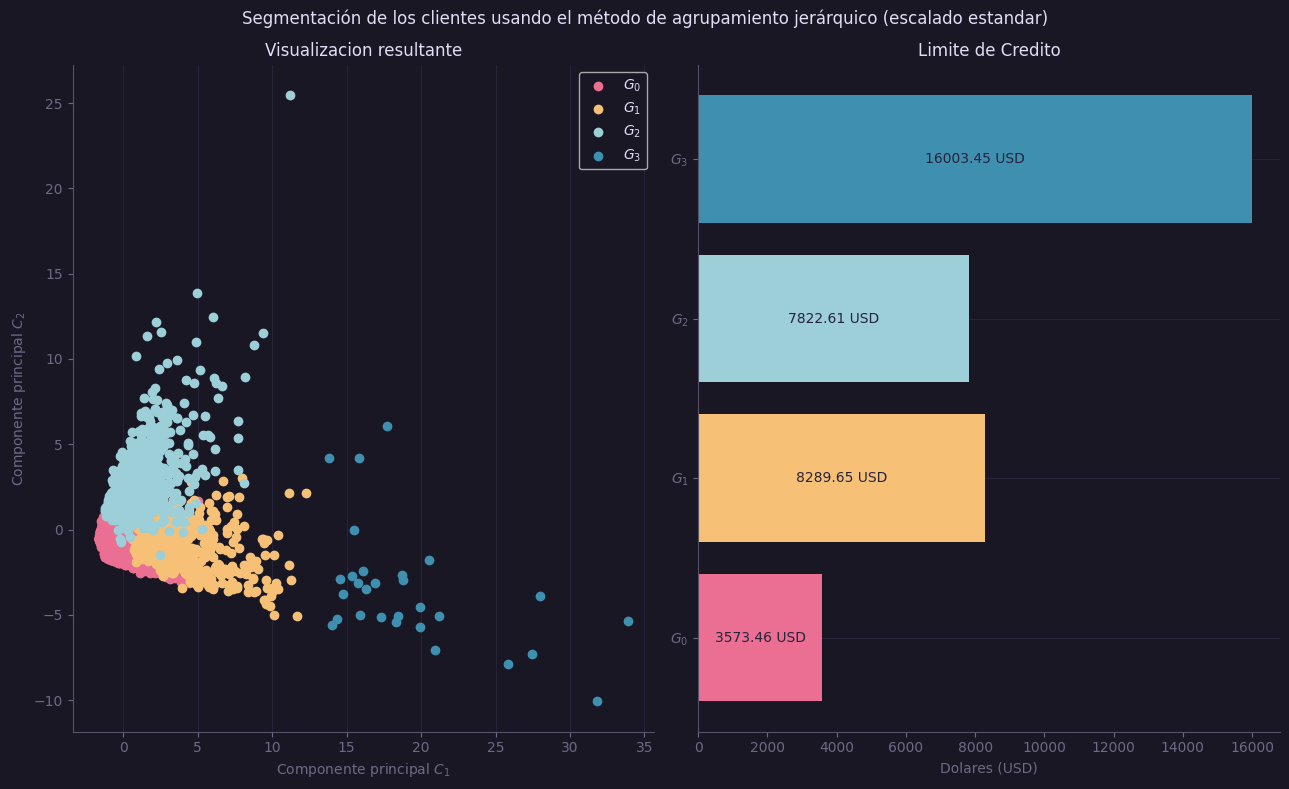

In [12]:
#obtenemos las categorias predichas
predictions = jerarq.labels_

#realizamos la visualizacion

dict_col = {
    0:'#eb6f92',
    1:'#f6c177',
    2:'#9ccfd8',
    3:'#3e8fb0',
    4:'#c4a7e7',
    5:'#e0def4'
}

leyendas = [
    "$G_0$",
    '$G_1$',
    '$G_2$',
    '$G_3$',
    '$G_5$'
]

cred_lim1 = [np.mean(x["CREDIT_LIMIT"][predictions == i]) for i in range(0,n_cluster1)]

a = sorted(range(len(cred_lim1)), key=lambda k: cred_lim1[k])

# Visualizamos la prediccion para observar los resultados del algoritmo de clasificación, comenzando con el escalado estandar

plt.figure(figsize=(13,8))

#Visualizacion de la prediccion usando el escalado de datos de tipo estandar
plt.subplot(1,2,1)
plt.grid()
for i in range(0,n_cluster1):
    plt.scatter(vis_x[:,0][predictions == i],vis_x[:,1][predictions == i], c=dict_col[i])
plt.xlabel('Componente principal $C_1$')
plt.ylabel('Componente principal $C_2$')
plt.legend(leyendas)
plt.title('Visualizacion resultante')

plt.subplot(1,2,2)
for i in range(0,len(np.unique(predictions))):
    plt.barh(leyendas[i],cred_lim1[i],color = dict_col[i])
    plt.text(cred_lim1[i]/2,i,f"{cred_lim1[i]:.02f} USD",ha='center',va='center',color='#26233a')
plt.xlabel('Dolares (USD)')
plt.title('Limite de Credito')



plt.suptitle('Segmentación de los clientes usando el método de agrupamiento jerárquico (escalado estandar)')
plt.tight_layout()
plt.show()


In [13]:
m_list = []
tab = pd.DataFrame()
for i in range(0,np.shape(x)[1]):
    for j in a:
        m_list.append(np.mean(x[x.columns[i]][predictions == j]))
    tab[x.columns[i]] = m_list
    m_list = []

tab = tab.rename(index={0:'Grupo A', 1:'Grupo B', 2:'Grupo C', 3: 'Grupo D'})
tab = tab.transpose()
tab

,Grupo A,Grupo B,Grupo C,Grupo D
BALANCE,925.87,4433.29,3269.68,5706.94
PURCHASES,634.66,569.09,5079.53,25277.00
ONEOFF_PURCHASES,329.49,359.64,3325.11,18378.88
INSTALLMENTS_PURCHASES,305.44,209.53,1755.51,6898.13
CASH_ADVANCE,405.33,4647.37,474.37,1922.94
CASH_ADVANCE_TRX,1.64,13.80,1.47,3.79
PURCHASES_TRX,10.58,8.40,69.98,146.72
CREDIT_LIMIT,3573.46,7822.61,8289.65,16003.45
PAYMENTS,1047.46,3917.88,4405.57,25550.58
PRC_FULL_PAYMENT,0.17,0.05,0.16,0.46


<div style = 'text-align:justify'>

Como se observa aca, el resultado de la tranformacion con la funcion de Yeo-Johnson realizo un escalado mas afin a una distribucion estandar. Por lo que los grupos se encuentran mas mezclados, con esto se explica que se tenga una variacion menos pronunciada con respecto a los diferentes grupos de estudio.

</div>

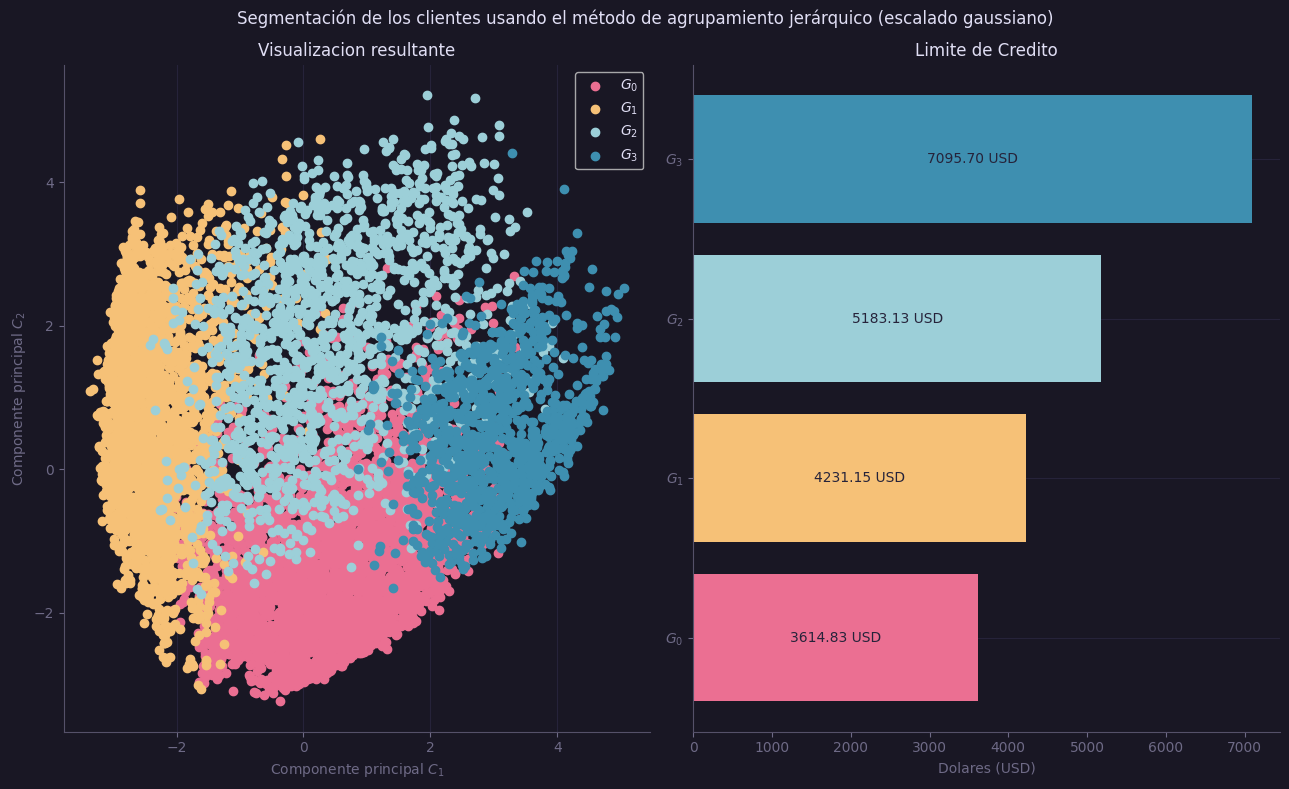

In [14]:
#Observemos el limite de credito de cada grupo, es interesante notar que dependiendo de los
#parametros y el escalado, se pueden notar tendencias diferentes, el escalado con potencias
#o gaussiano, pareciera que tiene la bondad de limpiar valores atipicos, aunque aumenta el
#mezclado de ciertas categorias, por lo que no es de extrañar que muchos de los resultados finales difieran de los del apartado anterior.
predictions2 = jerarq2.labels_
#list comprehension para generar un vector con los promedios de credito para cada grupo
cred_lim2 = [np.mean(x["CREDIT_LIMIT"][predictions2 == i]) for i in range(0,n_cluster2)]
b = sorted(range(len(cred_lim2)), key=lambda k: cred_lim2[k])
#Voy a realizar un grafico de barras para comparar los resultados de ambos escalados.
plt.figure(figsize=(13,8))
plt.subplot(1,2,1)
plt.grid()
for i in range(0,n_cluster2):
    plt.scatter(vis_x2[:,0][predictions2 == i],vis_x2[:,1][predictions2 == i], c=dict_col[i])
plt.xlabel('Componente principal $C_1$')
plt.ylabel('Componente principal $C_2$')
plt.legend(leyendas)
plt.title('Visualizacion resultante')

plt.subplot(1,2,2)
for i in range(0,len(np.unique(predictions))):
    plt.barh(leyendas[i],cred_lim2[i],color = dict_col[i])
    plt.text(cred_lim2[i]/2,i,f"{cred_lim2[i]:.02f} USD",ha='center',va='center',color='#26233a')
plt.xlabel('Dolares (USD)')
plt.title('Limite de Credito')

plt.suptitle('Segmentación de los clientes usando el método de agrupamiento jerárquico (escalado gaussiano)')
plt.tight_layout()
plt.show()


In [15]:
m_list = []
tab = pd.DataFrame()
for i in range(0,np.shape(x)[1]):
    for j in b:
        m_list.append(np.mean(x[x.columns[i]][predictions2 == j]))
    tab[x.columns[i]] = m_list
    m_list = []

tab = tab.rename(index={0:'Grupo A', 1:'Grupo B', 2:'Grupo C', 3: 'Grupo D'})
tab = tab.transpose()
tab.style

,Grupo A,Grupo B,Grupo C,Grupo D
BALANCE,625.928154,2318.702887,2728.037759,1483.765869
PURCHASES,654.269730,47.209627,1531.355574,3600.514799
ONEOFF_PURCHASES,322.429090,43.075831,898.583716,2311.189353
INSTALLMENTS_PURCHASES,332.434278,4.181603,632.988757,1289.325446
CASH_ADVANCE,13.416801,2126.478184,2215.756787,16.422266
CASH_ADVANCE_TRX,0.091270,6.880550,7.535811,0.058566
PURCHASES_TRX,10.932804,0.662868,24.751351,45.461538
CREDIT_LIMIT,3614.826452,4231.147824,5183.129129,7095.700890
PAYMENTS,882.049609,1714.031574,2700.757556,3337.543161
PRC_FULL_PAYMENT,0.208544,0.040242,0.060538,0.345664


## Metodo de k-medias

<div style = 'text-align:justify'>

Se implementa el modelo de k-medias en las siguientes lineas de código, además de esto se muestra la respectiva visualización más adelante.

</div>

In [16]:
#Metodo de k-medias
k = 4

k_medias1 = KMeans( n_clusters = k, n_init=10)
k_medias1 = k_medias1.fit( x_std )
k_medias2 = KMeans( n_clusters = k, n_init=10)
k_medias2 = k_medias2.fit( x_tr )

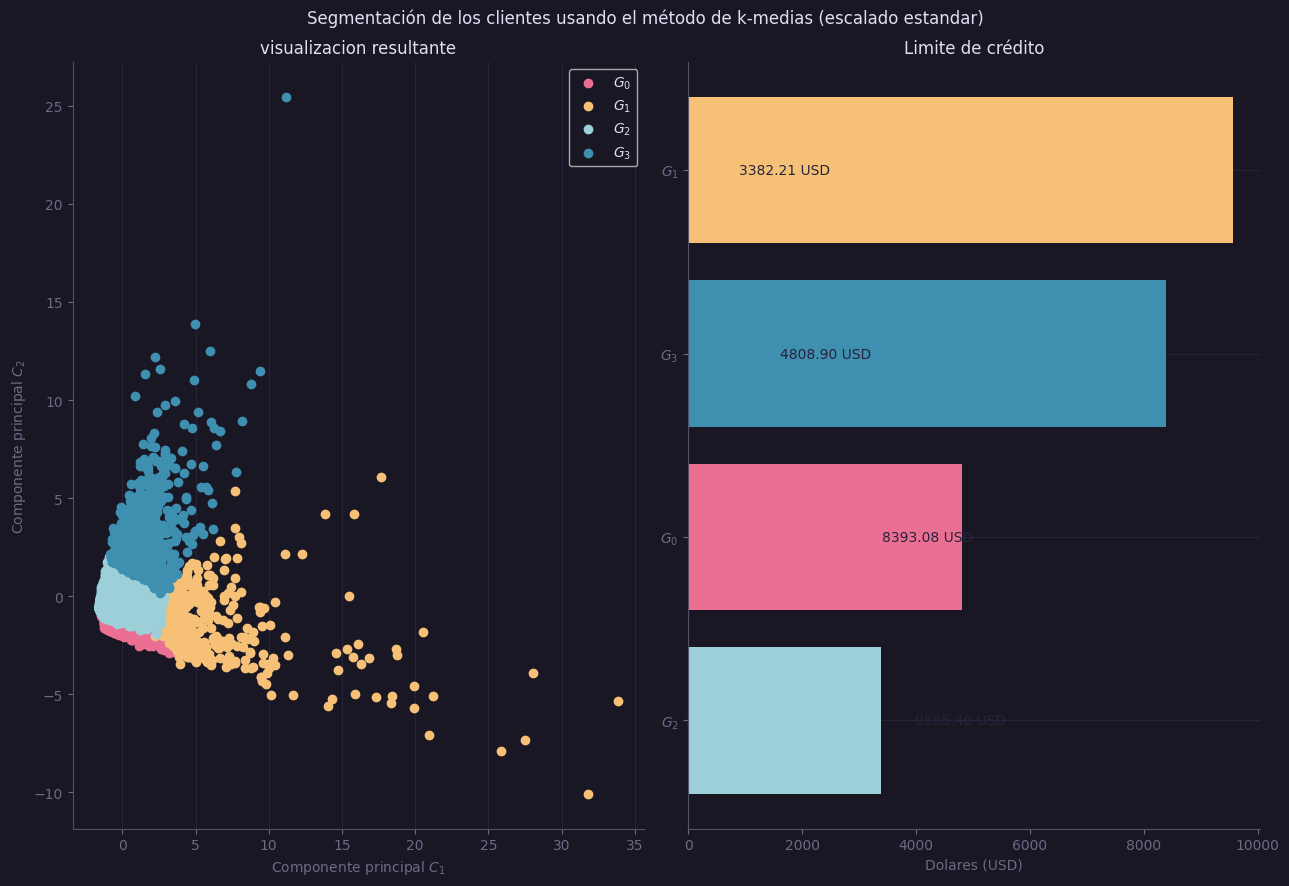

In [17]:
#obtenemos las categorias predichas
predictions = k_medias1.labels_

#realizamos la visualizacion

dict_col = {
    0:'#eb6f92',
    1:'#f6c177',
    2:'#9ccfd8',
    3:'#3e8fb0',
    4:'#c4a7e7',
    5:'#e0def4'
}

leyendas = [
    "$G_0$",
    '$G_1$',
    '$G_2$',
    '$G_3$',
    '$G_5$'
]

cred_lim1 = [np.mean(x["CREDIT_LIMIT"][predictions == i]) for i in range(0,n_cluster1)]
a = sorted(range(len(cred_lim1)), key=lambda k: cred_lim1[k])

# Visualizamos la prediccion para observar los resultados del algoritmo de clasificación, comenzando con el escalado estandar

plt.figure(figsize=(13,9))

#Visualizacion de la prediccion usando el escalado de datos de tipo estandar
plt.subplot(1,2,1)
plt.grid()
for i in range(0,n_cluster1):
    plt.scatter(vis_x[:,0][predictions == i],vis_x[:,1][predictions == i], c=dict_col[i])
plt.xlabel('Componente principal $C_1$')
plt.ylabel('Componente principal $C_2$')
plt.legend(leyendas)
plt.title('visualizacion resultante')

plt.subplot(1,2,2)
for j in a:
    plt.barh(leyendas[j],cred_lim1[j],color = dict_col[j])

for j in a:
    plt.text(x=cred_lim1[j]/2 ,y=a[j],s=f"{cred_lim1[j]:.02f} USD",ha='center',va='center',color='#26233a')

plt.xlabel("Dolares (USD)")
plt.title('Limite de crédito')



plt.suptitle('Segmentación de los clientes usando el método de k-medias (escalado estandar)')
plt.tight_layout()
plt.show()

In [18]:
m_list = []
tab = pd.DataFrame()
for i in range(0,np.shape(x)[1]):
    for j in a:
        m_list.append(np.mean(x[x.columns[i]][predictions == j]).round(2))
    tab[x.columns[i]] = m_list
    m_list = []

tab = tab.rename(index={0:'Grupo A', 1:'Grupo B', 2:'Grupo C', 3: 'Grupo D'})
tab = tab.transpose()
tab.style

,Grupo A,Grupo B,Grupo C,Grupo D
BALANCE,1132.280000,140.260000,4947.140000,3661.250000
PURCHASES,578.500000,1259.500000,638.930000,7868.750000
ONEOFF_PURCHASES,336.020000,614.650000,392.270000,5158.320000
INSTALLMENTS_PURCHASES,242.790000,644.950000,246.780000,2712.000000
CASH_ADVANCE,507.110000,91.390000,4754.740000,612.000000
CASH_ADVANCE_TRX,2.080000,0.320000,13.630000,1.980000
PURCHASES_TRX,9.800000,18.820000,9.660000,92.470000
CREDIT_LIMIT,3382.210000,4808.900000,8393.080000,9565.400000
PAYMENTS,1007.710000,1548.110000,3936.510000,7446.400000
PRC_FULL_PAYMENT,0.040000,0.750000,0.040000,0.230000


El método de k medias entrega que la población que posee el límite de crédito más alto es el Grupo D, con un total de 9565 Dólares, que es mucho menor al método de agrupamiento jerárquico. Esta discrepancia tiene que ver con el hecho de que el método de K-medias no solamente incluye a unos pocos valores anómalos, sino que incluye una población mucho más grande para el grupo D

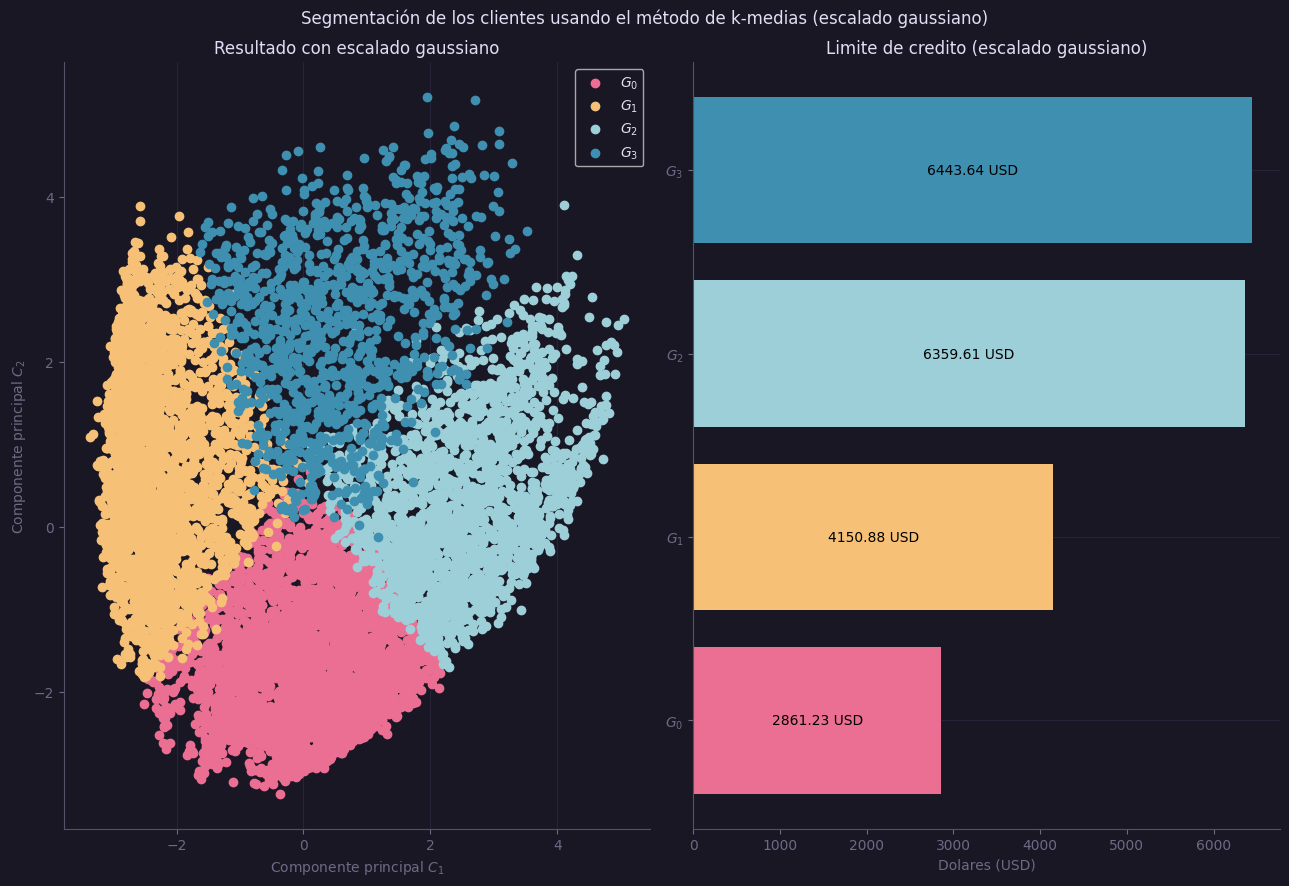

In [19]:
#Observemos el limite de credito de cada grupo, es interesante notar que dependiendo de los parametros
#y el escalado, se pueden notar tendencias diferentes, el escalado con potencias o gaussiano,
#pareciera que tiene la bondad de limpiar valores atipicos, aunque aumenta el mezclado de ciertas categorias
#, por lo que no es de extrañar que muchos de los resultados finales difieran de los del apartado anterior.
predictions2 = k_medias2.labels_
#list comprehension para generar un vector con los promedios de credito para cada grupo
cred_lim2 = [np.mean(x["CREDIT_LIMIT"][predictions2 == i]) for i in range(0,n_cluster2)]
b = sorted(range(len(cred_lim2)), key=lambda k: cred_lim2[k],reverse=True)
#Voy a realizar un grafico de barras para comparar los resultados de ambos escalados.
plt.figure(figsize=(13,9))
plt.subplot(1,2,1)
plt.grid()
for i in range(0,n_cluster2):
    plt.scatter(vis_x2[:,0][predictions2 == i],vis_x2[:,1][predictions2 == i], c=dict_col[i])
plt.xlabel('Componente principal $C_1$')
plt.ylabel('Componente principal $C_2$')
plt.legend(leyendas)
plt.title('Resultado con escalado gaussiano')

plt.subplot(1,2,2)
for j in range(0,4):
    plt.barh(leyendas[j],cred_lim2[j],color = dict_col[j])
    plt.text(x = cred_lim2[j]/2,y = j,s = f"{cred_lim2[j]:.02f} USD",ha='center',va='center',color='black')

plt.xlabel('Dolares (USD)')
plt.title('Limite de credito (escalado gaussiano)')

plt.suptitle('Segmentación de los clientes usando el método de k-medias (escalado gaussiano)')
plt.tight_layout()
plt.show()

In [20]:
m_list = []
tab = pd.DataFrame()
for i in range(0,np.shape(x)[1]):
    for j in b:
        m_list.append(np.mean(x[x.columns[i]][predictions2 == j]))
    tab[x.columns[i]] = m_list
    m_list = []

tab = tab.rename(index={0:'Grupo A', 1:'Grupo B', 2:'Grupo C', 3: 'Grupo D'})
tab = tab.transpose()
tab.style

,Grupo A,Grupo B,Grupo C,Grupo D
BALANCE,3593.073402,1326.529616,2253.084398,412.782646
PURCHASES,1744.359964,2785.140613,52.669413,369.843314
ONEOFF_PURCHASES,1064.871174,1738.183476,38.288685,138.610016
INSTALLMENTS_PURCHASES,679.508559,1047.296115,14.419254,231.829237
CASH_ADVANCE,2866.907315,22.961633,2044.689668,30.398006
CASH_ADVANCE_TRX,9.213523,0.136806,6.740053,0.208174
PURCHASES_TRX,26.752669,35.389484,0.962107,8.414432
CREDIT_LIMIT,6443.638790,6359.605180,4150.879580,2861.231762
PAYMENTS,3331.567598,2779.892530,1663.136793,532.576374
PRC_FULL_PAYMENT,0.043586,0.298135,0.034793,0.198776


<div style = 'text-align:justify'>

## Interpretación del método de k-medias

Puede notarse que los resultados entre ambos tipos de escalado presentan una tendencia similar: dos grupos con un mayor limite de credito en sus tarjetas y dos grupos con un limite menor en sus tarjetas, con una diferencia de más de 2000 USD que los separa. De nuevo, el escalado puede jugar en contra, en cuanto a que el escalado realizado con `PowerTransformer` tiene un efecto de reducción de la variabilidad de los datos procesados, por lo que el efecto de valores atípicos se reduce significativamente, por lo que, para concluir, este segundo método pareciera que podría usarse para indicar una cota inferior de la que poder partir para segmentar a los clientes de la institución.


</div>